In [32]:
from pathlib import Path

import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from scipy.spatial import distance_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from shapely.geometry import MultiPoint
import aesara.tensor as at

DATA_DIR = Path("../data/processed")
MODEL_DIR = Path("../models")

data = gpd.read_file(DATA_DIR / "spatial_income_1880.gpkg").loc[::2]

xy = pd.DataFrame({"x": data.geometry.x, "y": data.geometry.y})
d = distance_matrix(xy, xy) / 1000
O_norm = (
    StandardScaler()
    .fit_transform(data.orthodox_proportion_ln.values.reshape(-1, 1))
    .flatten()
)
data["group"] = data.district.factorize()[0]

N = data.shape[0]
SEED = 42
N_CLUSTERS = len(data.group.unique())
print(f"total_income_ln mean: {data.total_income_ln.mean():.2}")

total_income_ln mean: 4.4


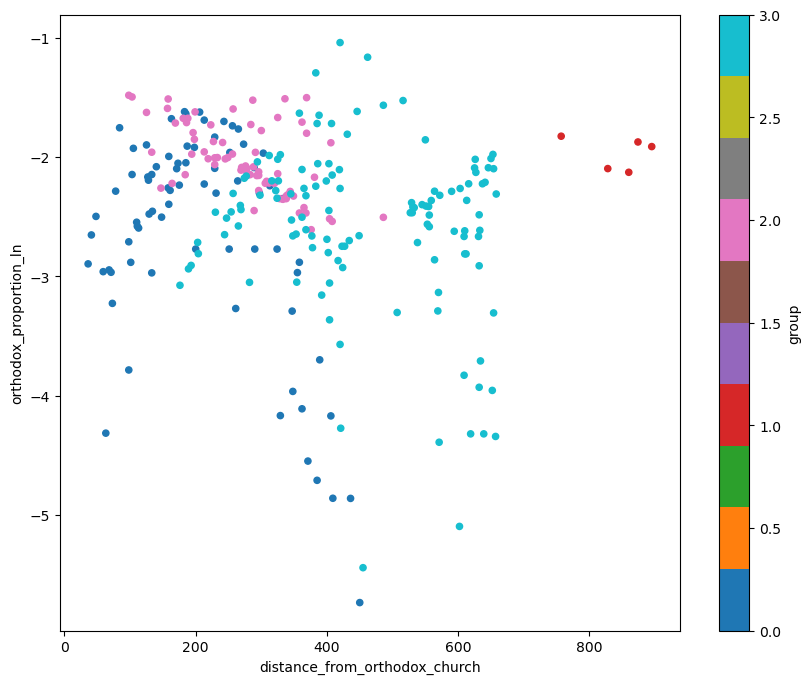

In [33]:
cluster_colors = plt.get_cmap("tab10")
data.plot(
    kind="scatter",
    x="distance_from_orthodox_church",
    y="orthodox_proportion_ln",
    c="group",
    cmap="tab10",
    figsize=(10, 8),
)
plt.show()

In [34]:
data.explore(
    column="group",
    categorical=True,
    cmap=cluster_colors,
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [35]:
data.explore(
    column="total_income_ln",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)


In [36]:
data.explore(
    column="orthodox_proportion",
    cmap="Reds",
    marker_kwds=dict(fill=True, radius=5),
    legend=True,
)

In [37]:
# with pm.Model() as model_1:
#     idx = data.group
#     W = pm.MutableData("W", data.total_income_ln)

#     θ = pm.Normal("θ", [0, 0], [0.1, 0.1], shape=2)

#     β = pm.MvNormal(
#         "β", mu=θ, cov=np.diagflat(np.array([0.1, 0.1])), shape=(N_CLUSTERS, 2)
#     )
#     μ = at.exp(β[idx, 0] + β[idx, 1] * W)
#     σ = pm.HalfNormal("σ", 0.01)

#     O = pm.Beta("O", mu=μ, sigma=σ, observed=data.orthodox_proportion)

#     prior_1 = pm.sample_prior_predictive()
#     posterior_1 = pm.sample(init="adapt_diag", return_inferencedata=True, target_accept=0.95)
#     posterior_prediction_1 = pm.sample_posterior_predictive(posterior_1)

In [38]:
# graph_1 = pm.model_to_graphviz(model_1)
# graph_1

In [39]:
# az.plot_posterior(posterior_1, grid=(N_CLUSTERS + 2, 2))
# plt.show()

In [40]:
# az.plot_trace(posterior_1)
# plt.show()

In [41]:
# az.plot_forest(posterior_1, combined=True, hdi_prob=0.94)
# plt.show()

In [42]:
# az.plot_ppc(posterior_prediction_1)
# plt.show()

# Model 2

Heavier spatial error model

$$ O_i \sim N(\mu_i, \sigma) $$
$$ \sigma \sim Exponential(10) $$
$$ \mu_i = \beta_{k[i],0} + \beta_{k[i],1} W + \gamma_i $$
$$ \beta_k \sim MvNormal \left( \theta, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ \theta \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix} \right) $$
$$ \gamma \sim MvNormal \left( \begin{bmatrix} 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}_{(i)}, \bold K \right) $$
$$ \bold K = \eta^2 exp \left( -\rho^2 D^2 \right) + \bold I_{(i)} * 0.01 $$
$$ \eta^2 \sim N(1, 0.1) $$
$$ \rho^2 \sim N() $$

In [43]:
with pm.Model() as model_2:
    idx = data.group
    W = pm.MutableData("W", data.total_income_ln)
    C = pm.MutableData("C", data.distance_from_orthodox_church) / 1000

    θ = pm.Normal("θ", [0, 0, 0], [0.1, 0.1, 0.1], shape=3)
    β = pm.MvNormal(
        "β", mu=θ, cov=np.diagflat(np.array([0.1, 0.1, 0.1])), shape=(N_CLUSTERS, 3)
    )

    η2 = pm.Normal("η²", 1, 0.1)
    ρ2 = pm.Normal("ρ²", 20, 5)
    K = η2 * at.exp(-ρ2 * at.power(d, 2)) + np.diag([0.01] * N)
    γ = pm.MvNormal("γ", mu=np.zeros(N), cov=K, shape=N)

    μ = β[idx, 0] + β[idx, 1] * W + β[idx, 2] * C + γ
    σ = pm.Exponential("σ", 10)
    O = pm.Normal("O", mu=μ, sigma=σ, observed=O_norm)

    prior_predictive = pm.sample_prior_predictive(samples=100, random_seed=SEED)
    idata = pm.sample(
        draws=1000,
        tune=1000,
        init="adapt_diag",
        return_inferencedata=True,
        target_accept=0.95,
        random_seed=SEED,
    )
    posterior_predictive = pm.sample_posterior_predictive(
        idata,
        random_seed=SEED,
    )

Sampling: [O, β, γ, η², θ, ρ², σ]


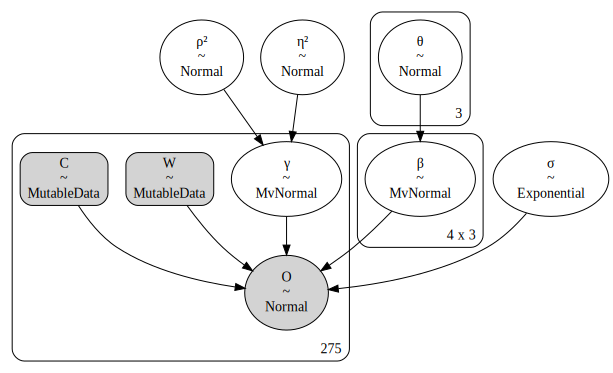

In [44]:
graph_2 = pm.model_to_graphviz(model_2)
graph_2

[Text(0.5, 1.0, 'prior'),
 Text(0.5, 0, 'distance, km'),
 Text(0, 0.5, 'covariance')]

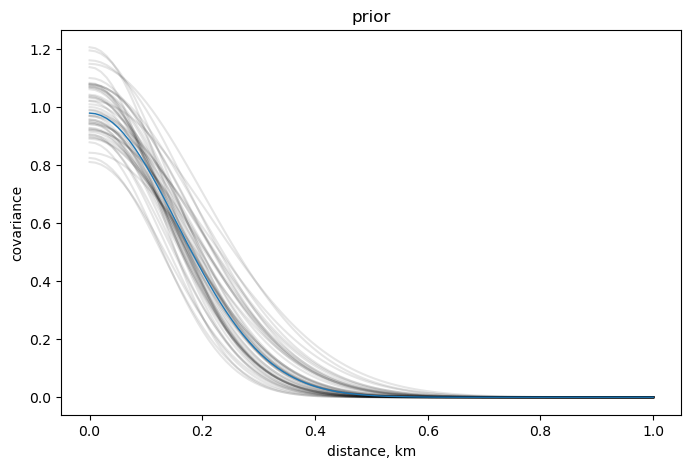

In [47]:
# Prior sanity check
_, ax = plt.subplots(1, 1, figsize=(8, 5))
cov = prior_predictive['prior']
x = np.linspace(0, 1, 100)
median_cov = (np.median(cov["η²"][0].values) * at.exp(-np.median(cov["ρ²"][0].values) * (x**2))).eval()

ax.plot(
    x,
    (cov["η²"][0, ::2].values[:, None] * np.exp(-cov["ρ²"][0, ::2].values[:, None] * (x**2))).T,
    "k",
    alpha=0.1,
)
ax.plot(x, median_cov, lw=1)

ax.set(
    title="prior",
    # ylim=(-0.1, 2),
    xlabel="distance, km",
    ylabel="covariance",
)


NameError: name 'idata' is not defined

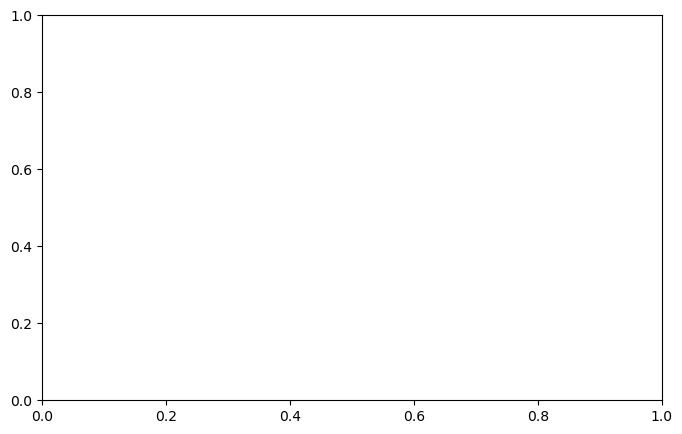

In [46]:
# Posterior sanity check
_, ax = plt.subplots(1, 1, figsize=(8, 5))
cov = idata['posterior']
x = np.linspace(0, 1, 100)
median_cov = (np.median(cov["η²"][0].values) * at.exp(-np.median(cov["ρ²"][0].values) * (x**2))).eval()

ax.plot(
    x,
    (cov["η²"][0, ::50].values[:, None] * np.exp(-cov["ρ²"][0, ::50].values[:, None] * (x**2))).T,
    "k",
    alpha=0.1,
)
ax.plot(x, median_cov, lw=1)

ax.set(
    title="posterior",
    # ylim=(-0.1, 2),
    xlabel="distance, km",
    ylabel="covariance",
)

In [ ]:
az.plot_posterior(idata, var_names=["~γ"], grid=[N_CLUSTERS + 2, 3])
plt.show()

NameError: name 'idata' is not defined

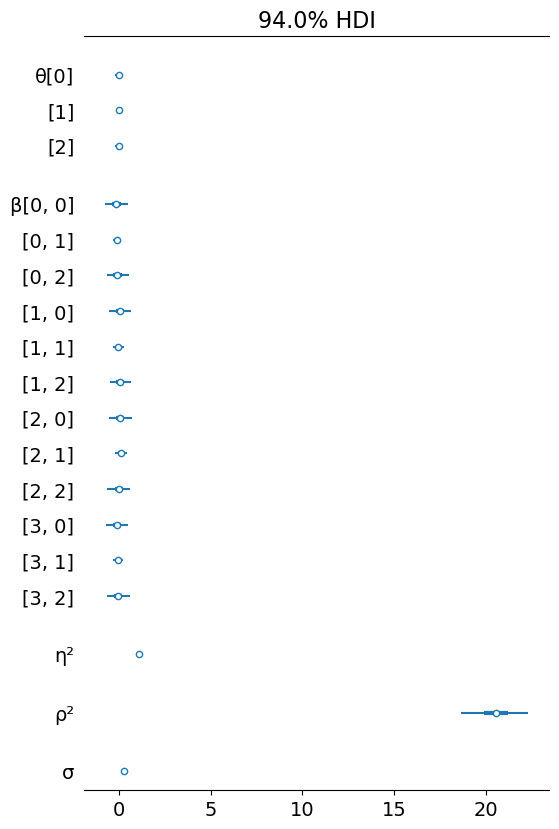

In [ ]:
az.plot_forest(idata, combined=True, hdi_prob=0.94, var_names=["~γ"])
plt.show()

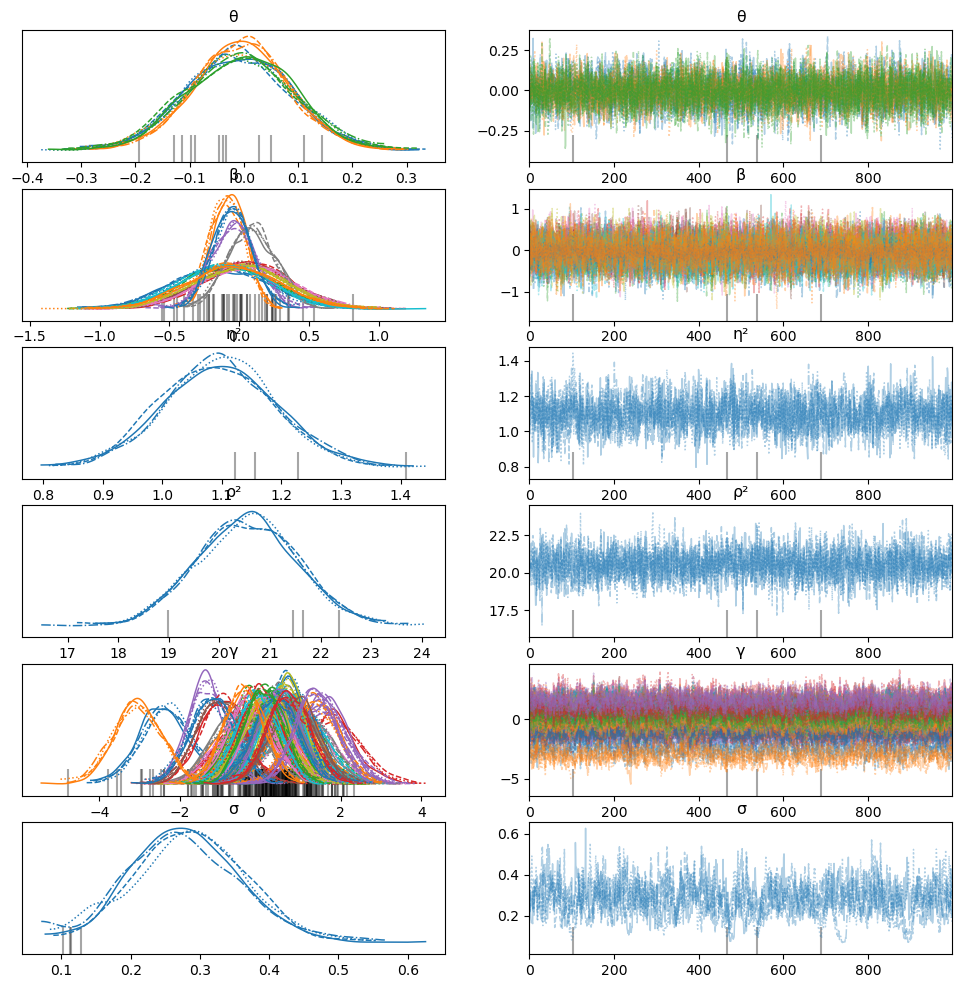

In [ ]:
az.plot_trace(idata)
plt.show()

In [ ]:
az.plot_ppc(posterior_predictive)
plt.show()

NameError: name 'posterior_predictive' is not defined